In [22]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import yaml
import torch
from tqdm.auto import tqdm
import shutil

In [23]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 248.5/460.4 GB disk)


In [24]:
from ultralytics import YOLO

In [25]:
model = YOLO("../colab_runs/weights2/best.pt")

In [26]:
results=model.predict(source="../data/data_YOLO3/val/images/",conf=0.25, save = True)


image 1/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1000669184.jpg: 640x640 1 Car, 202.5ms
image 2/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1003159552.jpg: 640x640 1 Car, 158.0ms
image 3/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1007681536.jpg: 640x640 1 Car, 174.6ms
image 4/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1008467968.jpg: 640x640 1 Car, 226.2ms
image 5/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1009909760.jpg: 640x640 1 Car, 353.3ms
image 6/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1010171904.jpg: 640x640 1 Car, 196.9ms
image 7/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/images/1010368512.jpg: 640x640 1 Car, 233.0ms
image 8/433 /Users/damidoum/Desktop/Data_challenge/notebooks/../data/data_YOLO3/val/image

In [30]:
def visualize_predictions(number, results, class_names):
    # Iterate over the images in the directory
    for i in range(number): 
        # Construct the full path to the image file
        image_path = results[i].path
        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the image shape (height, width)
        image_shape = image.shape[:2]

        # Create an array of colors for bounding boxes
        num_classes = len(class_names)
        colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
        result = results[i]
        # Iterate over the predictions and draw bounding boxes
        
        if len(result.boxes.cls) == 0: continue
        class_id = int(result.boxes.cls[0].int())
        confidence = float(result.boxes[0].conf)
        x1 = int(result.boxes.xyxy[0][0])
        y1 = int(result.boxes.xyxy[0][1])
        x2 = int(result.boxes.xyxy[0][2])
        y2 = int(result.boxes.xyxy[0][3])
        print(x1, y1, x2, y2)

        # # Scale the bounding box coordinates to match the image shape
        # x = int(x * image_shape[1])
        # y = int(y * image_shape[0])
        # width = int(width * image_shape[1])
        # height = int(height * image_shape[0])

        # Get the class name
        class_name = class_names[class_id]

        # Get the color for the bounding box
        color = colors[class_id]

        # Draw the bounding box rectangle and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), tuple(color.tolist()), 2)
        label = f'{class_name}: {confidence:.2f}'
        # cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, tuple(color.tolist()), 2)

        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

0 132 638 575


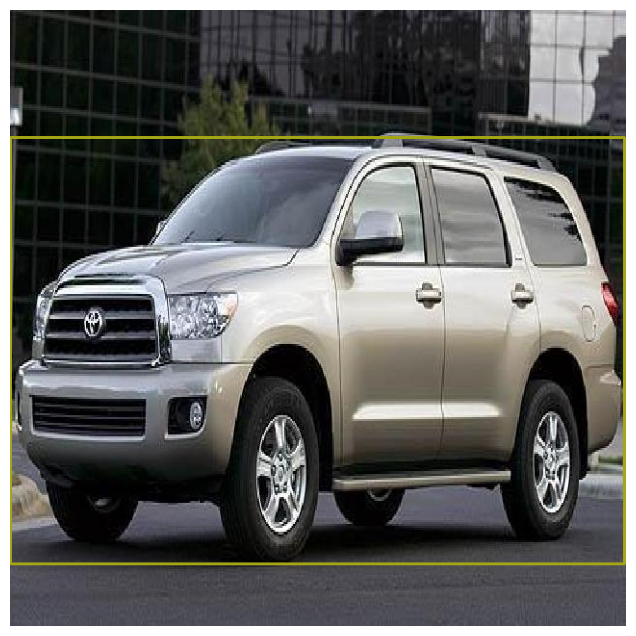

16 203 619 540


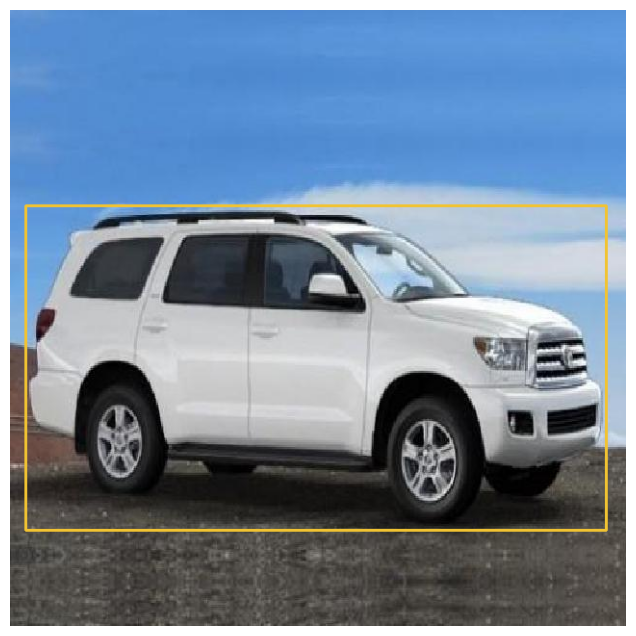

62 128 603 572


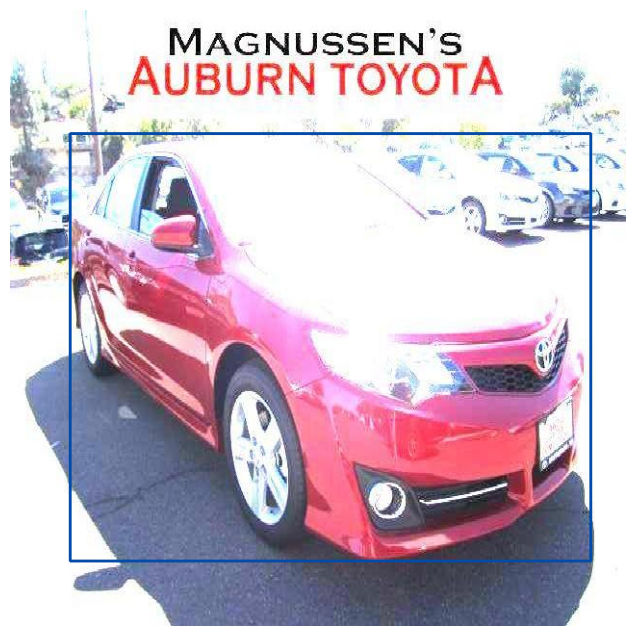

10 78 638 572


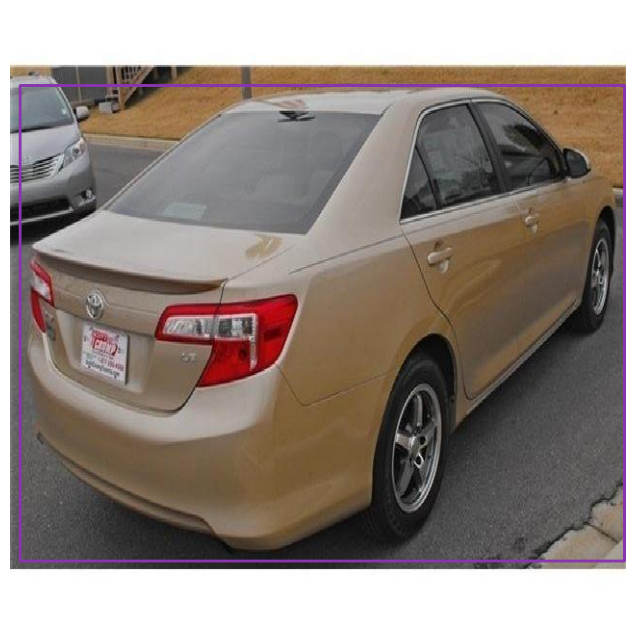

134 224 500 458


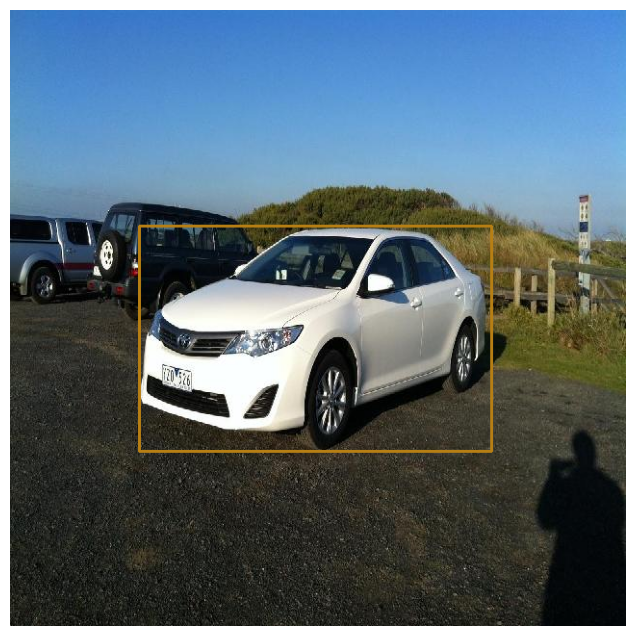

75 123 603 538


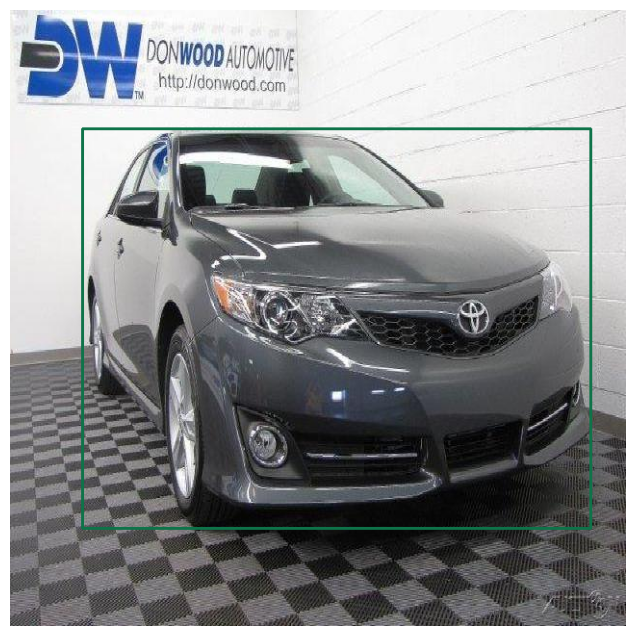

102 119 522 574


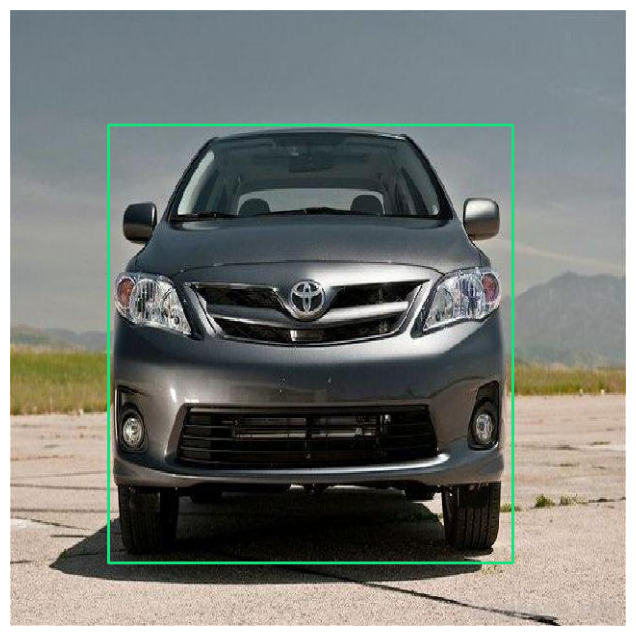

50 85 605 602


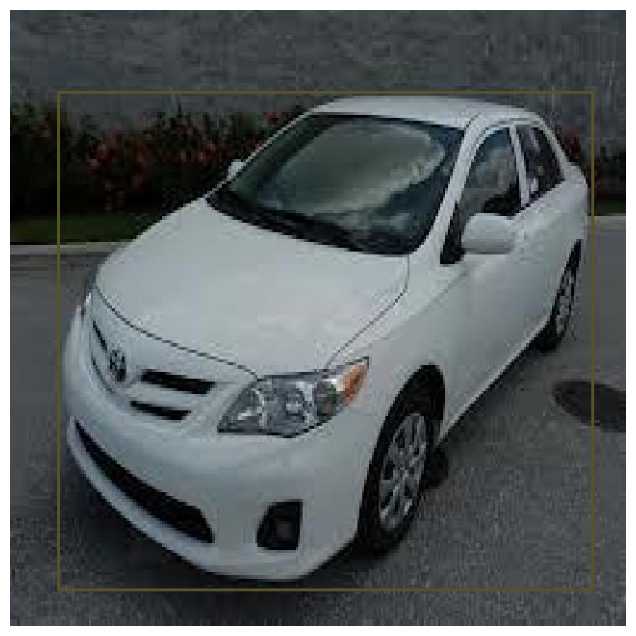

97 92 609 491


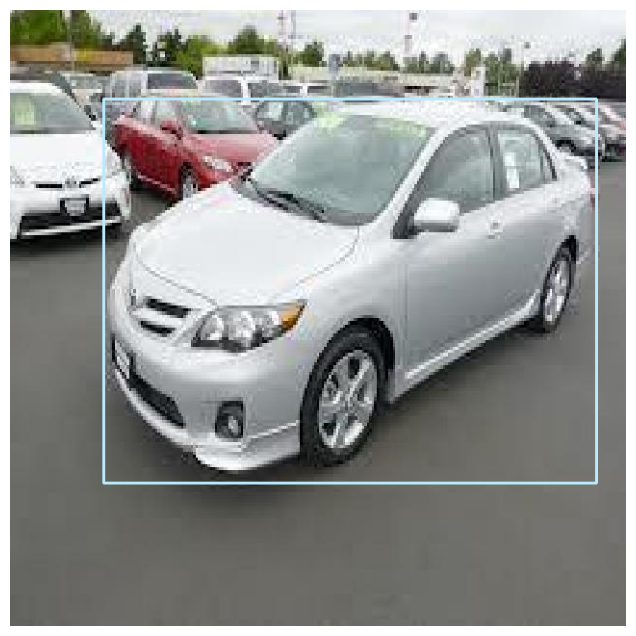

44 214 594 594


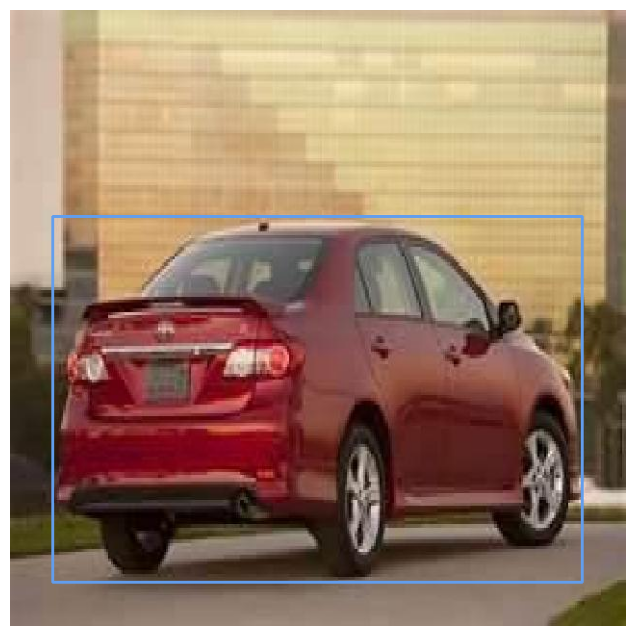

In [31]:
visualize_predictions(10, results, results[0].names)

## Evaluation des performances

In [33]:
from shapely.geometry import Polygon
def local_IoU(
    xmin_pred_i,
    xmax_pred_i,
    ymin_pred_i,
    ymax_pred_i,
    xmin_true_i,
    xmax_true_i,
    ymin_true_i,
    ymax_true_i,
):
    """This function calculates the IoU for the image i.

    Args:
        xmin_pred_i: Value of the prediction min x-axis.
        xmax_pred_i: Value of the prediction max x-axis.
        ymin_pred_i: Value of the prediction min y-axis.
        ymax_pred_i: Value of the prediction max y-axis.
        xmin_true_i: Value of the true min x-axis.
        xmax_true_i: Value of the true max x-axis.
        ymin_true_i: Value of the true min y-axis.
        ymax_true_i: Value of the true max y-axis.

    Returns:
        The return value is the intersection over union.

    """
    if (xmin_true_i, xmax_true_i, ymin_true_i, ymax_true_i) == (0, 0, 0, 0):
        if (xmin_pred_i, xmax_pred_i, ymin_pred_i, ymax_pred_i) == (
            0,
            0,
            0,
            0,
        ):
            return 1

        else:
            return 0

    else:
        box_pred_i = [
            [xmin_pred_i, ymin_pred_i],
            [xmax_pred_i, ymin_pred_i],
            [xmax_pred_i, ymax_pred_i],
            [xmin_pred_i, ymax_pred_i],
        ]
        box_true_i = [
            [xmin_true_i, ymin_true_i],
            [xmax_true_i, ymin_true_i],
            [xmax_true_i, ymax_true_i],
            [xmin_true_i, ymax_true_i],
        ]
        poly_1 = Polygon(box_pred_i)
        poly_2 = Polygon(box_true_i)
        try:
            iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
            return iou
        except:
            return 0

In [119]:
filenames_val = [result.path.split('/')[-1] for result in results]
res = np.empty((len(filenames_val),10))

In [120]:
annotation = pd.read_csv('../data/train_annotation/_annotation.csv')
annotation = annotation[annotation['im_name'].isin(filenames_val)]

In [121]:
import sys
sys.path.append('../script/')
from utils import *

In [122]:
_, labels_normalized = normalize_images_and_boxes(annotation, results[0].orig_shape, "../data/all_images/")

In [124]:
for i, filename_val in enumerate(filenames_val):
    res[i, 0] = annotation[annotation['im_name'] == filename_val]["class"].values[0]
    res[i, 1:5] = labels_normalized[i]
    if len(results[i].boxes.cls) != 0:
        res[i, 5] = 1
        res[i, 6:] = results[i].boxes.xyxy[0]   
    else :
        res[i, 5] = 0
        res[i, 6:] = [0, 0, 0, 0]

In [128]:
res = pd.DataFrame(res, columns=['class', 'x1', 'y1', 'x2', 'y2', 'pred', 'pred_x1', 'pred_y1', 'pred_x2', 'pred_y2'])


class          x1          y1          x2          y2  pred     pred_x1  \
0      1.0    7.680000  125.968254  638.720000  581.079365   1.0    0.635315   
1      1.0   20.480000  203.093333  619.520000  539.306667   1.0   16.541992   
2      1.0   60.000000  134.666667  601.000000  577.333333   1.0   62.538757   
3      1.0   18.000000   76.000000  633.000000  569.333333   1.0   10.723450   
4      1.0  132.839506  221.487603  499.259259  464.793388   1.0  134.333130   
..     ...         ...         ...         ...         ...   ...         ...   
428    1.0    1.000000  174.666667  631.000000  486.666667   1.0    0.000000   
429    1.0   67.063389  111.692845  527.399741  571.867365   1.0   64.251114   
430    1.0   30.476190  182.365591  608.507937  584.946237   1.0   27.051575   
431    1.0   36.800000  135.466667  540.000000  513.066667   1.0   37.037781   
432    1.0   56.000000   65.066667  576.000000  572.800000   1.0   63.810608   

        pred_y1     pred_x2     pred_y2  
0    132.385574  638.411743  575.029358  
1    203.342529  619.819458  540.513977  
2    128.967407  603.132996  572.593628  
3     78.122864  638.448730  572.951599  
4    224.505554  500.292908  458.463135  
..          ...         ...         ...  
428  170.355576  625.424683  471.076416  
429  123.844833  529.708130  570.012817  
430  179.357239  609.513123  583.587097  
431  137.362305  539.359497  515.954346  
432   71.612244  580.551819  566.404846  

[433 rows x 10 columns]

In [129]:
res["IOU"] = res.apply(lambda row: local_IoU(row['x1'], row['x2'], row['y1'], row['y2'], row['pred_x1'], row['pred_x2'], row['pred_y1'], row['pred_y2']), axis=1)

In [136]:
res["IOU"].mean()

0.9288507989504424